In [30]:
# 1. Configuración inicial y carga de datos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from darts import TimeSeries
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import optuna
import logging
import json
import pickle
import os
from tqdm import tqdm

# Configurar logging
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)
tf.random.set_seed(42)
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [31]:
# Cargar datos
df = pd.read_csv('monthly_data.csv')
df['DATES'] = pd.to_datetime(df['DATES'])
df.set_index('DATES', inplace=True)

df = df.dropna()
df.head()

,PEN
DATES,
1994-12-31,2.185
1995-01-31,2.194
1995-02-28,2.237
1995-03-31,2.258
1995-04-30,2.245


In [32]:
# Split train-test
train_size = int(len(df) * 0.8)
train = df['PEN'].values[:train_size]
test = df['PEN'].values[train_size:]

In [33]:
def load_hyperparameters(model_name):
    filename = f'best_hyperparameters_{model_name}.json'
    try:
        with open(filename, 'r') as f:
            return json.load(f)
    except FileNotFoundError:
        return None

In [34]:
def save_hyperparameters(params, model_name):
    filename = f'best_hyperparameters_{model_name}.json'
    with open(filename, 'w') as f:
        json.dump(params, f)
    print(f"Hiperparámetros guardados en {filename}")

In [35]:
# 2. Funciones de utilidad
def create_sequences(data, seq_length):
    X, y = [], []
    data_array = data.reshape(-1, 1) if len(data.shape) == 1 else data
    for i in range(len(data_array) - seq_length):
        X.append(data_array[i:(i + seq_length)])
        y.append(data_array[i + seq_length])
    return np.array(X), np.array(y)

def save_hyperparameters(params, model_name):
    filename = f'best_hyperparameters_{model_name}.json'
    with open(filename, 'w') as f:
        json.dump(params, f)
    print(f"Hiperparámetros guardados en {filename}")

def save_model_and_scaler(model, scaler, model_name='lstm'):
    """Guarda el modelo y el scaler"""
    model_filename = f'{model_name}_model.h5'
    model.save(model_filename)
    
    scaler_filename = f'{model_name}_scaler.pkl'
    with open(scaler_filename, 'wb') as f:
        pickle.dump(scaler, f)
    
    print(f"Modelo guardado en {model_filename}")
    print(f"Scaler guardado en {scaler_filename}")

def load_model_and_scaler(model_name='lstm'):
    """Carga el modelo y el scaler guardados"""
    try:
        model_filename = f'{model_name}_model.h5'
        scaler_filename = f'{model_name}_scaler.pkl'
        
        if os.path.exists(model_filename) and os.path.exists(scaler_filename):
            model = tf.keras.models.load_model(model_filename)
            with open(scaler_filename, 'rb') as f:
                scaler = pickle.load(f)
            print(f"Modelo y scaler cargados exitosamente")
            return model, scaler
        else:
            print("No se encontraron archivos guardados del modelo")
            return None, None
    except Exception as e:
        print(f"Error cargando modelo o scaler: {str(e)}")
        return None, None

In [36]:
# 3. Optimización y entrenamiento
def optimize_lstm(train_data, force_optimization=False, n_splits=3):
    if not force_optimization:
        loaded_params = load_hyperparameters('lstm')
        if loaded_params is not None:
            return loaded_params

    def objective(trial):
        params = {
            'sequence_length': trial.suggest_int('sequence_length', 3, 12),
            'lstm_units_1': trial.suggest_int('lstm_units_1', 32, 128),
            'lstm_units_2': trial.suggest_int('lstm_units_2', 16, 64),
            'dropout_1': trial.suggest_float('dropout_1', 0.1, 0.5),
            'dropout_2': trial.suggest_float('dropout_2', 0.1, 0.5),
            'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True),
            'batch_size': trial.suggest_categorical('batch_size', [16, 32, 64])
        }
        
        scaler = MinMaxScaler()
        scaled_data = scaler.fit_transform(train_data.reshape(-1, 1))
        X, y = create_sequences(scaled_data, params['sequence_length'])
        
        tscv = TimeSeriesSplit(n_splits=n_splits)
        cv_scores = []
        
        for train_idx, val_idx in tscv.split(X):
            X_train_fold, X_val_fold = X[train_idx], X[val_idx]
            y_train_fold, y_val_fold = y[train_idx], y[val_idx]
            
            model = Sequential([
                LSTM(params['lstm_units_1'], return_sequences=True, 
                     input_shape=(params['sequence_length'], 1)),
                Dropout(params['dropout_1']),
                LSTM(params['lstm_units_2']),
                Dropout(params['dropout_2']),
                Dense(1)
            ])
            
            model.compile(optimizer=Adam(learning_rate=params['learning_rate']), 
                         loss='mse')
            
            history = model.fit(X_train_fold, y_train_fold,
                              validation_data=(X_val_fold, y_val_fold),
                              epochs=50, batch_size=params['batch_size'],
                              verbose=0)
            
            cv_scores.append(history.history['val_loss'][-1])
            
            tf.keras.backend.clear_session()
        
        return np.mean(cv_scores)

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=50)
    
    best_params = study.best_params
    save_hyperparameters(best_params, 'lstm')
    
    return best_params


In [37]:
def train_lstm_model_with_cv(train_data, force_optimization=False, n_splits=3):
    # Intentar cargar hiperparámetros guardados
    loaded_params = load_hyperparameters('lstm')
    if loaded_params is not None and not force_optimization:
        print("Cargando hiperparámetros guardados para LSTM...")
        best_params = loaded_params
    else:
        print("Optimizando hiperparámetros para LSTM...")
        best_params = optimize_lstm(train_data, force_optimization, n_splits)
        save_hyperparameters(best_params, 'lstm')
    
    # Intentar cargar modelo guardado
    loaded_model, loaded_scaler = load_model_and_scaler('lstm')
    if loaded_model is not None and not force_optimization:
        print("Cargando modelo LSTM guardado...")
        return loaded_model, loaded_scaler, best_params, None
    
    print("Entrenando nuevo modelo LSTM...")
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_data.reshape(-1, 1))
    X_train, y_train = create_sequences(train_scaled, best_params['sequence_length'])
    
    model = Sequential([
        LSTM(best_params['lstm_units_1'], return_sequences=True, 
             input_shape=(best_params['sequence_length'], 1)),
        Dropout(best_params['dropout_1']),
        LSTM(best_params['lstm_units_2']),
        Dropout(best_params['dropout_2']),
        Dense(1)
    ])
    
    model.compile(optimizer=Adam(learning_rate=best_params['learning_rate']), 
                 loss='mse')
    
    history = model.fit(X_train, y_train,
                       epochs=100,
                       batch_size=best_params['batch_size'],
                       verbose=1)
    
    # Guardar modelo y scaler
    print("Guardando modelo LSTM...")
    save_model_and_scaler(model, scaler, 'lstm')
    
    return model, scaler, best_params, history

In [46]:
def step_by_step_forecast(
    model, 
    train_data, 
    test_data, 
    sequence_length,
    scaler,
    retrain=False, 
    progress_bar=None, 
    model_name='lstm'
):
    forecast_filename = f'{model_name}_forecast_{"retrain" if retrain else "no_retrain"}.pkl'
    
    # Intentar cargar la serie forecast si existe
    if os.path.exists(forecast_filename):
        print(f"Cargando forecast guardado de {forecast_filename}")
        with open(forecast_filename, 'rb') as f:
            return pickle.load(f)
    
    predictions = []
    # Usar solo los últimos puntos del entrenamiento para la secuencia inicial
    current_sequence = train_data[-sequence_length:].copy()
    
    # Obtener el índice temporal
    if isinstance(test_data, TimeSeries):
        test_index = test_data.time_index
    else:
        # Si test_data es un numpy array, crear un índice temporal
        test_index = pd.date_range(
            start=df.index[train_size],  # Usar el índice del DataFrame original
            periods=len(test_data),
            freq='M'
        )
    
    for i in tqdm(range(len(test_data)), desc="Generating predictions"):
        # Preparar la secuencia de entrada
        X_test = scaler.transform(current_sequence.reshape(-1, 1))
        X_test = X_test[-sequence_length:].reshape(1, sequence_length, 1)
        
        # Hacer predicción
        pred_scaled = model.predict(X_test, verbose=0)
        pred = scaler.inverse_transform(pred_scaled)[0, 0]
        predictions.append(pred)
        
        # Obtener el valor real dependiendo del tipo de datos
        if isinstance(test_data, TimeSeries):
            actual_value = test_data.values()[i]
        else:
            actual_value = test_data[i]
            
        # Actualizar la secuencia con el valor real
        current_sequence = np.append(current_sequence[1:], actual_value)
        
        # Reentrenamiento (si es necesario)
        if retrain:
            # Solo usar datos hasta el punto actual
            if isinstance(test_data, TimeSeries):
                test_values = test_data.values()[:i+1]
            else:
                test_values = test_data[:i+1]
                
            train_update = np.concatenate([
                scaler.transform(train_data.reshape(-1, 1)),
                scaler.transform(test_values.reshape(-1, 1))
            ])
            X_train, y_train = create_sequences(train_update, sequence_length)
            model.fit(X_train, y_train, epochs=1, batch_size=32, verbose=0)
        
        if progress_bar:
            progress_bar.update(100 // len(test_data))
    
    # Crear TimeSeries con las predicciones
    forecast = TimeSeries.from_times_and_values(
        times=test_index,
        values=np.array(predictions).reshape(-1, 1),
        freq='M'  # Frecuencia mensual
    )
    
    # Guardar el forecast
    print(f"Guardando forecast en {forecast_filename}")
    with open(forecast_filename, 'wb') as f:
        pickle.dump(forecast, f)
    
    return forecast

In [40]:
# Transform the serie en returns
def return_series(series):
    return series.pct_change().dropna()

In [41]:
# 5. Análisis de trading
def implement_trading_strategy_lstm(real_returns, predicted_returns):
    if isinstance(real_returns, list):
        real_returns_pd = pd.Series(real_returns)
    elif isinstance(real_returns, np.ndarray):
        real_returns_pd = pd.Series(real_returns)
    else:
        real_returns_pd = real_returns

    if isinstance(predicted_returns, list):
        predicted_returns_pd = np.array(predicted_returns)
    elif isinstance(predicted_returns, np.ndarray):
        predicted_returns_pd = predicted_returns
    else:
        predicted_returns_pd = np.array(predicted_returns)

    positions = np.where(predicted_returns_pd > 0, 1, -1)
    strategy_returns = real_returns_pd * positions

    return strategy_returns

def calculate_performance_metrics_timeseries(real_returns, strategy_returns):
    if isinstance(real_returns, np.ndarray):
        real_returns_pd = pd.Series(real_returns)
    elif isinstance(real_returns, list):
        real_returns_pd = pd.Series(real_returns)
    else:
        real_returns_pd = real_returns

    if isinstance(strategy_returns, np.ndarray):
        strategy_returns_pd = pd.Series(strategy_returns)
    elif isinstance(strategy_returns, list):
        strategy_returns_pd = pd.Series(strategy_returns)
    else:
        strategy_returns_pd = strategy_returns

    total_return = (1 + strategy_returns_pd).prod() - 1
    annualized_return = (1 + total_return) ** (12 / len(strategy_returns_pd)) - 1
    sharpe_ratio = np.sqrt(12) * strategy_returns_pd.mean() / strategy_returns_pd.std()
    max_drawdown = (strategy_returns_pd.cumsum() - strategy_returns_pd.cumsum().cummax()).min()
    hit_ratio = np.mean(np.sign(strategy_returns_pd) == np.sign(real_returns_pd)) * 100

    return {
        "Total Return": total_return,
        "Annualized Return": annualized_return,
        "Sharpe Ratio": sharpe_ratio,
        "Max Drawdown": max_drawdown,
        "Hit Ratio": hit_ratio
    }

def calculate_cumulative_return_timeseries(returns):
    if isinstance(returns, pd.Series):
        pass
    elif isinstance(returns, np.ndarray):
        returns = pd.Series(returns)
    else:
        raise ValueError("Input must be a pandas Series or numpy array.")

    return (1 + returns).cumprod() - 1

In [42]:
# 6. Ejecución del modelo y análisis
print("Entrenando modelo LSTM...")
model, scaler, best_params, history = train_lstm_model_with_cv(
    train,
    force_optimization=False,
    n_splits=3
)

Entrenando modelo LSTM...
Cargando hiperparámetros guardados para LSTM...
Modelo y scaler cargados exitosamente
Cargando modelo LSTM guardado...


In [47]:
forecast_no_retrain = step_by_step_forecast(
    model=model,
    train_data=train,
    test_data=test,
    sequence_length=best_params['sequence_length'],
    scaler=scaler,
    retrain=False,
    progress_bar=None,
    model_name='lstm'
)

Generating predictions: 100%|██████████| 72/72 [00:03<00:00, 20.61it/s]

Guardando forecast en lstm_forecast_no_retrain.pkl


In [49]:
# Predicciones con reentrenamiento
forecast_with_retrain = step_by_step_forecast(
    model=model,
    train_data=train,
    test_data=test,
    sequence_length=best_params['sequence_length'],
    scaler=scaler,
    retrain=True,
    progress_bar=None,
    model_name='lstm'
)

Generating predictions: 100%|██████████| 72/72 [00:13<00:00,  5.38it/s]

Guardando forecast en lstm_forecast_retrain.pkl


In [50]:
# Convertir arrays de NumPy a pandas Series con el índice temporal
test_index = df.index[train_size:] # Ajustar el índice según la secuencia
forecast_index = test_index

In [51]:
# Convertir los TimeSeries a arrays numpy
y_pred_no_retrain = forecast_no_retrain.values().flatten()
y_pred_with_retrain = forecast_with_retrain.values().flatten()

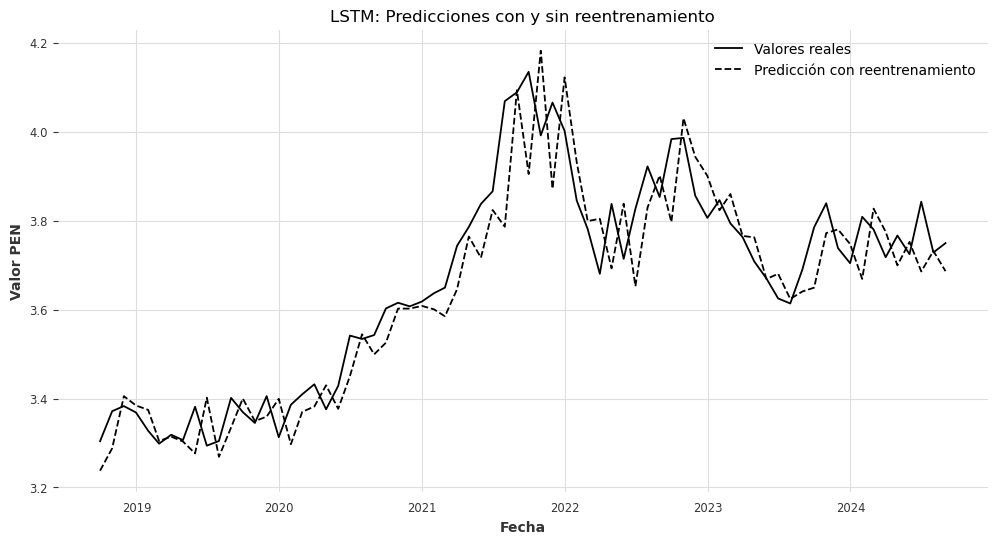

In [52]:
# Visualizar resultados
plt.figure(figsize=(12, 6))
plt.plot(test_index, 
         test, 
         label='Valores reales', 
         color='black')

#plt.plot(test_index, 
#         y_pred_no_retrain, 
#         label='Predicción sin reentrenamiento', 
#         linestyle='--')

plt.plot(test_index, 
         y_pred_with_retrain, 
         label='Predicción con reentrenamiento', 
         linestyle='--')

plt.legend()
plt.title('LSTM: Predicciones con y sin reentrenamiento')
plt.xlabel('Fecha')
plt.ylabel('Valor PEN')
plt.grid(True)
plt.show()

In [53]:
# Implementar estrategia de trading para ambos casos
real_returns = return_series(pd.Series(test, index=test_index))

# Extraer los valores numéricos de los TimeSeries y crear Series de pandas
y_pred_no_retrain = forecast_no_retrain.values().flatten()
y_pred_with_retrain = forecast_with_retrain.values().flatten()

pred_returns_no_retrain = return_series(pd.Series(y_pred_no_retrain, index=test_index))
pred_returns_with_retrain = return_series(pd.Series(y_pred_with_retrain, index=test_index))


In [54]:
print("\nAnalizando estrategias de trading...")
# Implementar estrategia de trading
strategy_returns_no_retrain = implement_trading_strategy_lstm(real_returns, pred_returns_no_retrain)
strategy_returns_with_retrain = implement_trading_strategy_lstm(real_returns, pred_returns_with_retrain)

# Calcular retornos acumulados
cumulative_real = calculate_cumulative_return_timeseries(real_returns)
cumulative_strategy_no_retrain = calculate_cumulative_return_timeseries(strategy_returns_no_retrain)
cumulative_strategy_with_retrain = calculate_cumulative_return_timeseries(strategy_returns_with_retrain)

# Ahora podemos crear el TimeSeries de Darts para la comparación
lstm_forecast_no_retrain_unscaled = forecast_no_retrain

lstm_forecast_with_retrain_unscaled = forecast_with_retrain



Analizando estrategias de trading...


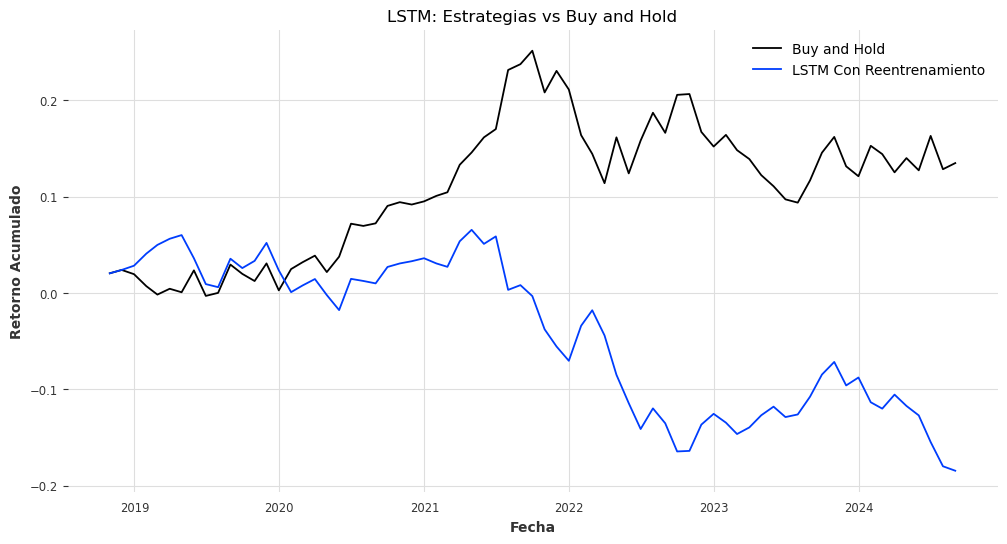

In [55]:
# Visualizar resultados de la estrategia
plt.figure(figsize=(12, 6))
plt.plot(cumulative_real.index, cumulative_real, label='Buy and Hold')
#plt.plot(cumulative_strategy_no_retrain.index, cumulative_strategy_no_retrain, 
#         label='LSTM Sin Reentrenamiento')
plt.plot(cumulative_strategy_with_retrain.index, cumulative_strategy_with_retrain, 
         label='LSTM Con Reentrenamiento')
plt.legend()
plt.title('LSTM: Estrategias vs Buy and Hold')
plt.xlabel('Fecha')
plt.ylabel('Retorno Acumulado')
plt.grid(True)
plt.show()

In [57]:
# Calcular métricas de rendimiento
metrics_buy_hold = calculate_performance_metrics_timeseries(real_returns, real_returns)
metrics_strategy_no_retrain = calculate_performance_metrics_timeseries(real_returns, strategy_returns_no_retrain)
metrics_strategy_with_retrain = calculate_performance_metrics_timeseries(real_returns, strategy_returns_with_retrain)

print("\nMétricas de rendimiento:")
print("\nBuy and Hold:")
for k, v in metrics_buy_hold.items():
    print(f"{k}: {v:.4f}")
print("\nEstrategia LSTM sin reentrenamiento:")
for k, v in metrics_strategy_no_retrain.items():
    print(f"{k}: {v:.4f}")
print("\nEstrategia LSTM con reentrenamiento:")
for k, v in metrics_strategy_with_retrain.items():
    print(f"{k}: {v:.4f}")


Métricas de rendimiento:

Buy and Hold:
Total Return: 0.1348
Annualized Return: 0.0216
Sharpe Ratio: 0.3437
Max Drawdown: -0.1285
Hit Ratio: 100.0000

Estrategia LSTM sin reentrenamiento:
Total Return: -0.1381
Annualized Return: -0.0248
Sharpe Ratio: -0.3290
Max Drawdown: -0.2233
Hit Ratio: 50.7042

Estrategia LSTM con reentrenamiento:
Total Return: -0.1844
Annualized Return: -0.0339
Sharpe Ratio: -0.4662
Max Drawdown: -0.2568
Hit Ratio: 50.7042


In [ ]:
# Guardar resultados
results = {
    'model': model,
    'scaler': scaler,
    'best_params': best_params,
    'forecasts': {
        'no_retrain': forecast_no_retrain,
        'with_retrain': forecast_with_retrain
    },
    'trading_metrics': {
        'buy_hold': metrics_buy_hold,
        'no_retrain': metrics_strategy_no_retrain,
        'with_retrain': metrics_strategy_with_retrain
    },
    'cumulative_returns': {
        'buy_hold': cumulative_real,
        'no_retrain': cumulative_strategy_no_retrain,
        'with_retrain': cumulative_strategy_with_retrain
    }
}

# Guardar resultados completos
with open('lstm_complete_results.pkl', 'wb') as f:
    pickle.dump(results, f)
print("Resultados completos guardados en 'lstm_complete_results.pkl'")

# Guardar también versión ligera (sin modelo)
light_results = {k: v for k, v in results.items() if k not in ['model', 'scaler']}
with open('lstm_light_results.pkl', 'wb') as f:
    pickle.dump(light_results, f)
print("Versión ligera de resultados guardada en 'lstm_light_results.pkl'")

Resultados completos guardados en 'lstm_complete_results.pkl'
Versión ligera de resultados guardada en 'lstm_light_results.pkl'


In [ ]:
# Función para cargar resultados
def load_results(light_version=True):
    """
    Carga los resultados guardados
    
    Parámetros:
    - light_version: Si True, carga versión sin modelo ni scaler
    """
    filename = 'lstm_light_results.pkl' if light_version else 'lstm_complete_results.pkl'
    try:
        with open(filename, 'rb') as f:
            return pickle.load(f)
    except FileNotFoundError:
        print(f"No se encontró el archivo {filename}")
        return None

In [ ]:
def plot_metrics_comparison(results):
    """
    Visualiza comparación de métricas clave entre estrategias
    """
    metrics = ['Total Return', 'Annualized Return', 'Sharpe Ratio', 'Hit Ratio']
    strategies = ['buy_hold', 'no_retrain', 'with_retrain']
    strategy_names = ['Buy & Hold', 'Sin Reentrenamiento', 'Con Reentrenamiento']
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Comparación de Métricas entre Estrategias', size=16)
    
    for i, metric in enumerate(metrics):
        ax = axes[i//2, i%2]
        values = [results['trading_metrics'][s][metric] for s in strategies]
        ax.bar(strategy_names, values)
        ax.set_title(metric)
        ax.grid(True, alpha=0.3)
        if metric.endswith('Return'):
            ax.set_ylabel('Porcentaje')
            # Convertir a porcentaje
            for j, v in enumerate(values):
                ax.text(j, v, f'{v*100:.1f}%', ha='center', va='bottom')
        else:
            for j, v in enumerate(values):
                ax.text(j, v, f'{v:.2f}', ha='center', va='bottom')
        
        # Rotar etiquetas si son largas
        ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

In [ ]:
# Función para visualizar retornos acumulados
def plot_cumulative_returns(results):
    """
    Visualiza los retornos acumulados de todas las estrategias
    """
    plt.figure(figsize=(15, 8))
    
    # Convertir datos a pandas Series si no lo son ya
    cumulative_returns = {}
    for key in ['buy_hold', 'no_retrain', 'with_retrain']:
        if isinstance(results['cumulative_returns'][key], pd.Series):
            cumulative_returns[key] = results['cumulative_returns'][key]
        else:
            cumulative_returns[key] = pd.Series(results['cumulative_returns'][key])
    
    # Plot cada estrategia
    plt.plot(cumulative_returns['buy_hold'], 
             'b-', label='Buy & Hold', linewidth=2)
    plt.plot(cumulative_returns['no_retrain'], 
             'r--', label='LSTM Sin Reentrenamiento', linewidth=2)
    plt.plot(cumulative_returns['with_retrain'], 
             'g--', label='LSTM Con Reentrenamiento', linewidth=2)
    
    plt.title('Retornos Acumulados por Estrategia')
    plt.xlabel('Tiempo')
    plt.ylabel('Retorno Acumulado')
    plt.legend(loc='best')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Añadir retornos finales como anotaciones
    final_returns = {
        'Buy & Hold': cumulative_returns['buy_hold'].iloc[-1],
        'Sin Reentrenamiento': cumulative_returns['no_retrain'].iloc[-1],
        'Con Reentrenamiento': cumulative_returns['with_retrain'].iloc[-1]
    }
    
    # Añadir texto con retornos finales
    text = "Retornos Finales:\n"
    for strategy, ret in final_returns.items():
        text += f"{strategy}: {ret*100:.1f}%\n"
    
    plt.text(0.02, 0.98, text,
             transform=plt.gca().transAxes,
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

In [ ]:
def print_results_summary(results):
    """
    Imprime un resumen de los resultados principales
    """
    print("\n=== RESUMEN DE RESULTADOS ===")
    
    print("\nParámetros óptimos del modelo:")
    for param, value in results['best_params'].items():
        print(f"{param}: {value}")
    
    print("\nMétricas de Trading:")
    strategies = {
        'Buy & Hold': 'buy_hold',
        'LSTM Sin Reentrenamiento': 'no_retrain',
        'LSTM Con Reentrenamiento': 'with_retrain'
    }
    
    for strategy_name, strategy_key in strategies.items():
        print(f"\n{strategy_name}:")
        metrics = results['trading_metrics'][strategy_key]
        for metric, value in metrics.items():
            if metric.endswith('Return'):
                print(f"{metric}: {value*100:.2f}%")
            else:
                print(f"{metric}: {value:.4f}")

Cargando resultados...

Visualizando métricas de comparación...


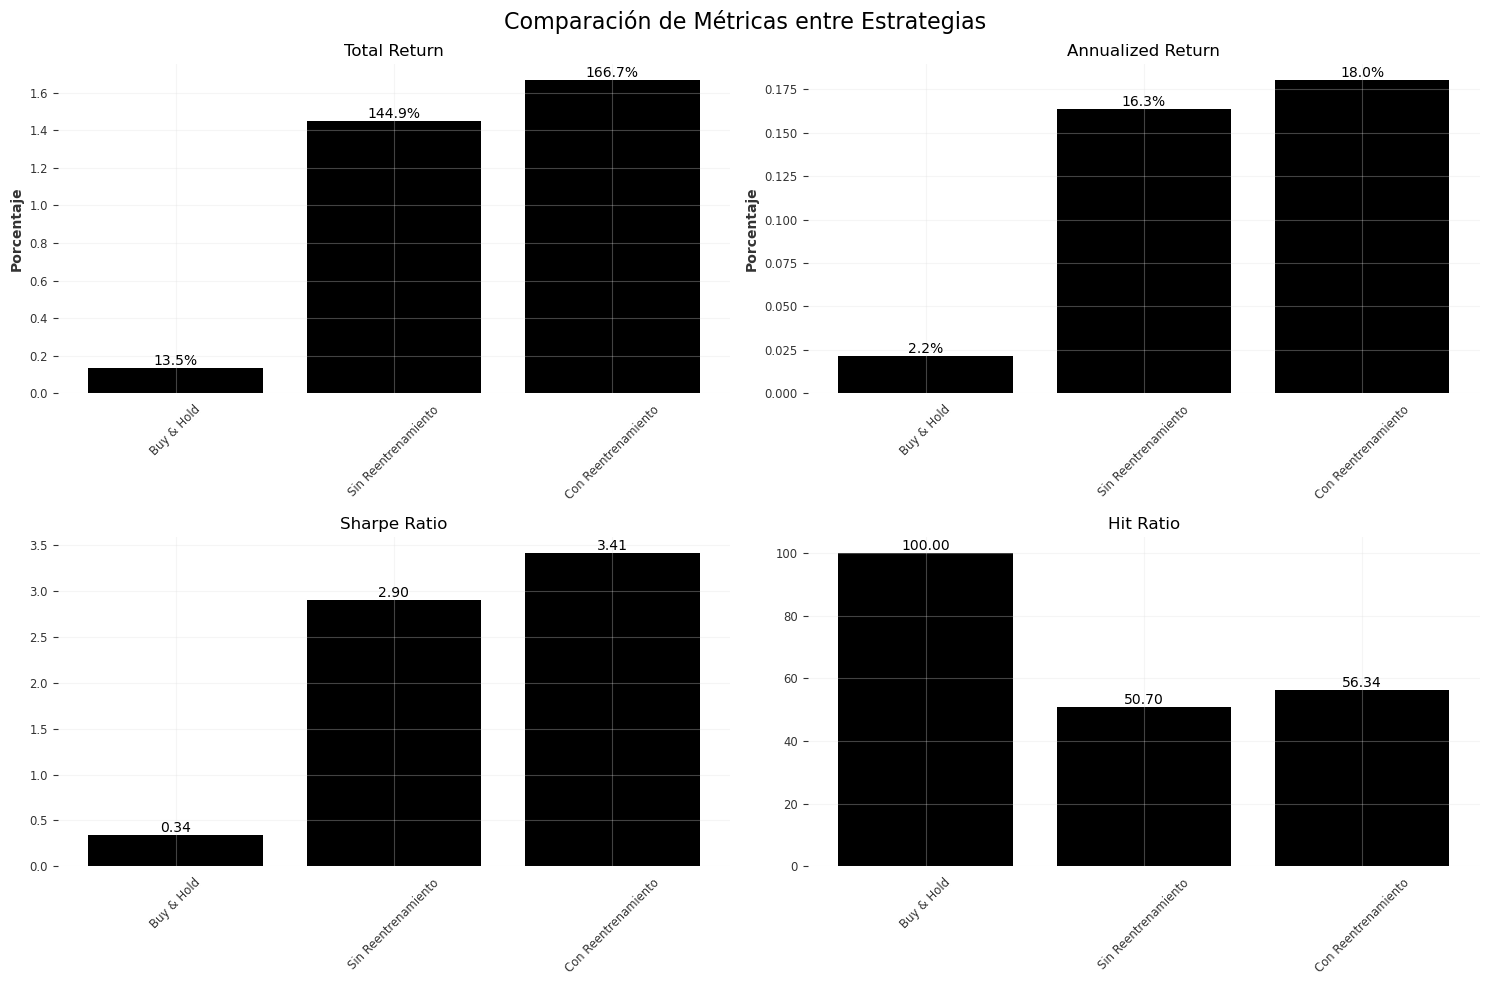


Visualizando retornos acumulados...


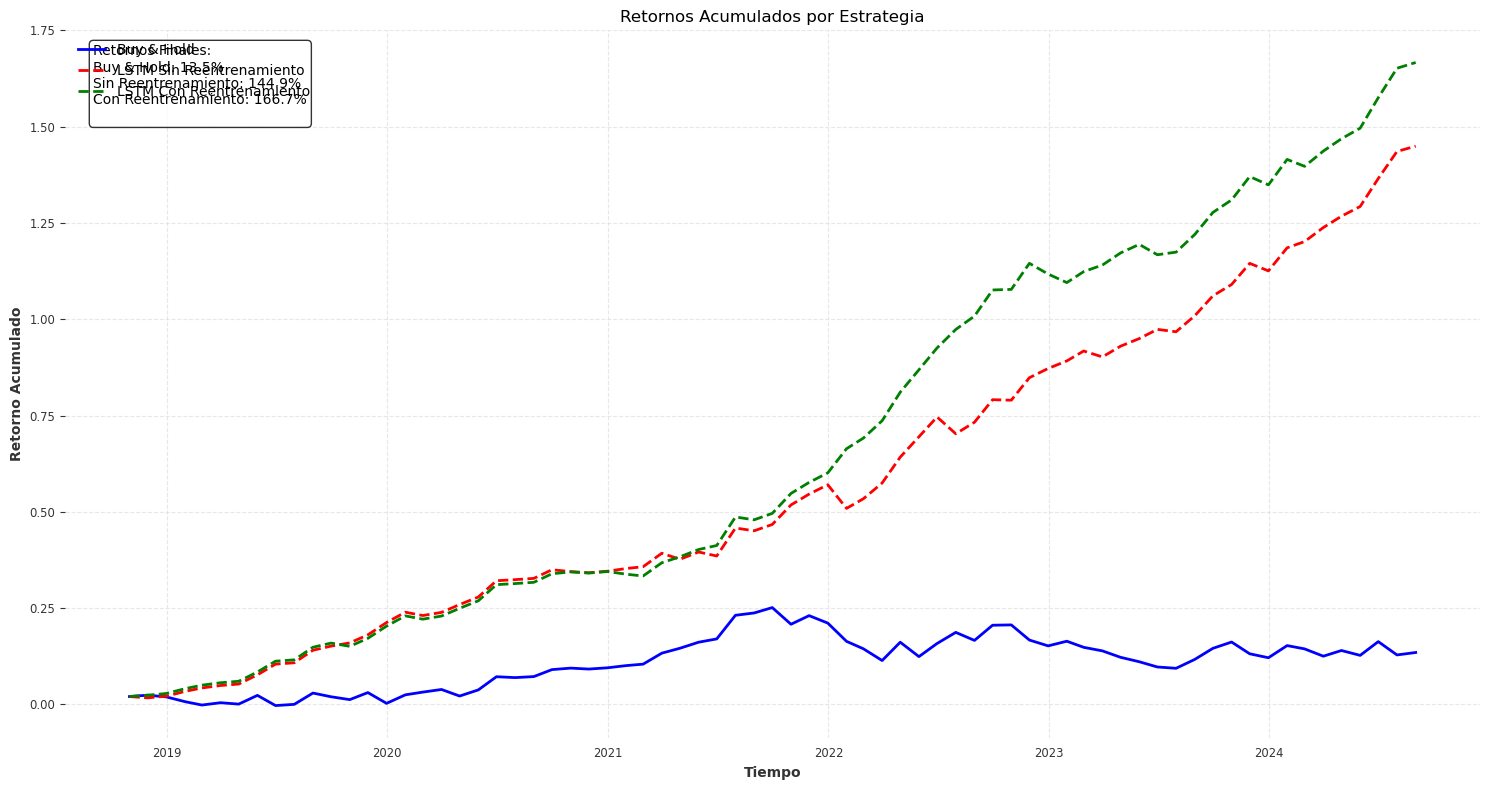


Imprimiendo resumen de resultados...

=== RESUMEN DE RESULTADOS ===

Parámetros óptimos del modelo:
sequence_length: 9
lstm_units_1: 125
lstm_units_2: 54
dropout_1: 0.18749033281654576
dropout_2: 0.18451663422947762
learning_rate: 0.009866321982467665
batch_size: 16

Métricas de Trading:

Buy & Hold:
Total Return: 13.48%
Annualized Return: 2.16%
Sharpe Ratio: 0.3437
Max Drawdown: -0.1285
Hit Ratio: 100.0000

LSTM Sin Reentrenamiento:
Total Return: 144.94%
Annualized Return: 16.35%
Sharpe Ratio: 2.8964
Max Drawdown: -0.0391
Hit Ratio: 50.7042

LSTM Con Reentrenamiento:
Total Return: 166.67%
Annualized Return: 18.03%
Sharpe Ratio: 3.4121
Max Drawdown: -0.0234
Hit Ratio: 56.3380


In [ ]:
# Cargar y mostrar resultados
print("Cargando resultados...")
loaded_results = load_results(light_version=True)

if loaded_results is not None:
    print("\nVisualizando métricas de comparación...")
    plot_metrics_comparison(loaded_results)
    
    print("\nVisualizando retornos acumulados...")
    plot_cumulative_returns(loaded_results)
    
    print("\nImprimiendo resumen de resultados...")
    print_results_summary(loaded_results)
else:
    print("No se pudieron cargar los resultados.")